In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
from argparse import ArgumentParser

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import cv2
import torch.nn.functional as F
import copy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


In [3]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [4]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# extracting the compessed Dataset
from zipfile import ZipFile

dataset = "/teamspace/studios/this_studio/Face_mask_detection_cnn/face-mask-dataset.zip"

with ZipFile(dataset, "r") as zip:
    zip.extractall()
    print("The dataset is extracted")

The dataset is extracted


In [6]:
DATA_DIR       = "/teamspace/studios/this_studio/Face_mask_detection_cnn/data"
CHECKPOINT_DIR = "/teamspace/studios/this_studio/Face_mask_detection_cnn"

In [7]:
# LightningModule
class MaskCNNLightning(pl.LightningModule):
    def __init__(self, num_classes=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool  = nn.MaxPool2d(2)
        self.flatten_dim = 64 * 30 * 30
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)); x = self.dropout(x)
        x = F.relu(self.fc2(x)); x = self.dropout(x)
        return self.fc3(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc",  acc,  on_epoch=True)
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc",  acc,  prog_bar=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y    = batch
        logits  = self(x)
        loss    = self.criterion(logits, y)
        preds   = torch.argmax(logits, dim=1)
        acc     = (preds == y).float().mean()
        self.log("test_loss", loss,    on_epoch=True, prog_bar=True)
        self.log("test_acc",  acc,     on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

# DataModule
class MaskDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, input_size=(128,128)):
        super().__init__()
        self.data_dir   = data_dir
        self.batch_size = batch_size
        self.transform  = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        full = datasets.ImageFolder(self.data_dir, transform=self.transform)
        n_total = len(full)
        n_train = int(0.8 * n_total)
        n_test  = n_total - n_train
        train_full, self.test_ds = random_split(full, [n_train, n_test])
        n_val = int(0.1 * n_train)
        n_train_final = n_train - n_val
        self.train_ds, self.val_ds = random_split(train_full, [n_train_final, n_val])

    def train_dataloader(self):
        return DataLoader(self.train_ds,batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val_ds,     batch_size=self.batch_size)
    def test_dataloader(self):
        return DataLoader(self.test_ds,    batch_size=self.batch_size)


In [8]:
# Instantiate DataModule and Model
dm = MaskDataModule(data_dir=DATA_DIR, batch_size=32, input_size=(128,128))
model = MaskCNNLightning(num_classes=2, lr=1e-3)

# Callbacks
early_stop = EarlyStopping("val_loss", patience=5, mode="min", verbose=True)
ckpt       = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename="best_mask_cnn",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

csv_logger = CSVLogger(save_dir="lightning_logs", name="mask_cnn")

In [9]:
# Trainer
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[early_stop, ckpt],
    logger=csv_logger
)

# Run
trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /teamspace/studios/this_studio/Face_mask_detection_cnn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv1     | Conv2d           | 896    | train
1 | conv2     | Conv2d           | 18.5 K | train
2 | pool      | MaxPool2d        | 0      | train
3 | fc1       | Linear           | 7.4 M  | train
4 | fc2       | Linear           | 8.3 K  | train
5 | fc3       | Linear           | 130    | train
6 | dropout   | Dropout          | 0      | train
7 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.4 M     Trainable params
0         Non-trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.320


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.268


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.251


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.216


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [10]:
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9424222111701965     │
│         test_loss         │    0.15254133939743042    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.15254133939743042, 'test_acc': 0.9424222111701965}]

In [17]:
path = "/teamspace/studios/this_studio/Face_mask_detection_cnn/lightning_logs/mask_cnn/version_0/metrics.csv"
df = pd.read_csv(path)
df

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
0,0,49,NaN,NaN,NaN,0.937500,NaN,0.255982,NaN,NaN
1,0,99,NaN,NaN,NaN,0.843750,NaN,0.322915,NaN,NaN
2,0,149,NaN,NaN,NaN,0.781250,NaN,0.581271,NaN,NaN
3,0,169,NaN,NaN,NaN,NaN,NaN,NaN,0.862583,0.320469
4,0,169,NaN,NaN,0.805443,NaN,0.425631,NaN,NaN,NaN
5,1,199,NaN,NaN,NaN,0.812500,NaN,0.340908,NaN,NaN
6,1,249,NaN,NaN,NaN,0.906250,NaN,0.266652,NaN,NaN
7,1,299,NaN,NaN,NaN,1.000000,NaN,0.105112,NaN,NaN
8,1,339,NaN,NaN,NaN,NaN,NaN,NaN,0.885762,0.267623
9,1,339,NaN,NaN,0.892424,NaN,0.278387,NaN,NaN,NaN


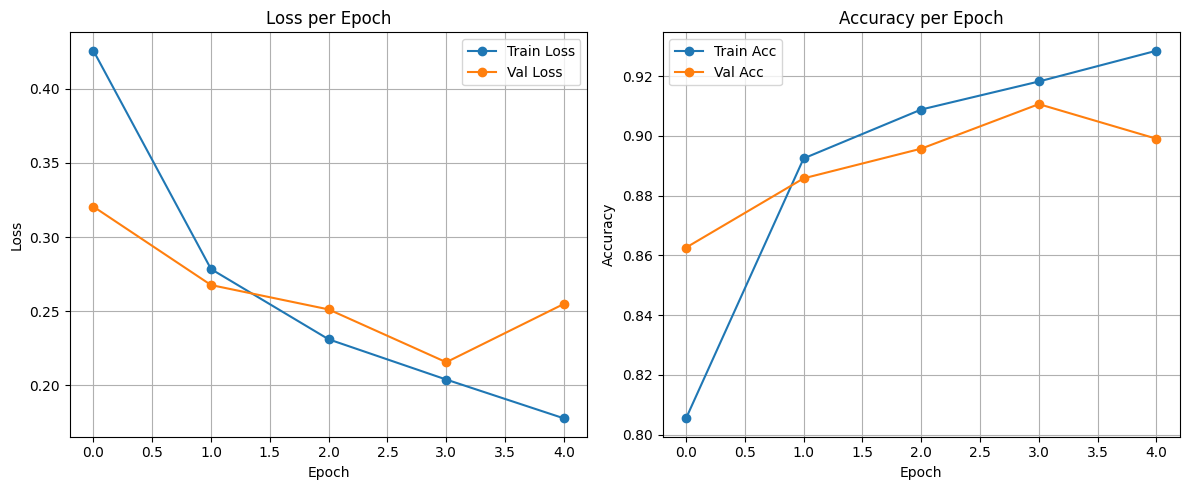

In [12]:

# only keep the epoch-level rows for train/val loss & acc
df_train = df[df['train_loss_epoch'].notna()]
df_val   = df[df['val_loss'].notna()]

epochs = df_train['epoch']

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, df_train['train_loss_epoch'], marker='o', label='Train Loss')
plt.plot(epochs, df_val['val_loss'],     marker='o', label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, df_train['train_acc_epoch'], marker='o', label='Train Acc')
plt.plot(epochs, df_val['val_acc'],     marker='o', label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
df_train

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
4,0,169,NaN,NaN,0.805443,NaN,0.425631,NaN,NaN,NaN
9,1,339,NaN,NaN,0.892424,NaN,0.278387,NaN,NaN,NaN
15,2,509,NaN,NaN,0.908790,NaN,0.231029,NaN,NaN,NaN
20,3,679,NaN,NaN,0.918168,NaN,0.203896,NaN,NaN,NaN
26,4,849,NaN,NaN,0.928466,NaN,0.177737,NaN,NaN,NaN


In [14]:
df_val

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
3,0,169,NaN,NaN,NaN,NaN,NaN,NaN,0.862583,0.320469
8,1,339,NaN,NaN,NaN,NaN,NaN,NaN,0.885762,0.267623
14,2,509,NaN,NaN,NaN,NaN,NaN,NaN,0.895695,0.251184
19,3,679,NaN,NaN,NaN,NaN,NaN,NaN,0.910596,0.215581
25,4,849,NaN,NaN,NaN,NaN,NaN,NaN,0.899007,0.254880
